# Data processing

### imports

In [1]:
import polars as pl

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(100)

from polars import col as c
import os
import matplotlib.pyplot as plt
import numpy as np
import holidays
from datetime import datetime, timedelta
from numpy.typing import ArrayLike, NDArray

### constants

In [2]:
DATA_DIR = "dataset"
US_HOLIDAYS = holidays.US()  # this is a dict-like object

### functions

In [3]:
def mape_f(y_true: ArrayLike, y_pred: ArrayLike) -> np.floating:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    metric = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return round(metric, 2)

### data

In [4]:
path = os.path.join("../", DATA_DIR, "train.csv")
train = pl.read_csv(path).with_columns(
    c("pickup_date").str.to_datetime("%Y-%m-%d %H:%M:%S")
)
path = os.path.join("../", DATA_DIR, "validation.csv")
validation = pl.read_csv(path).with_columns(
    c("pickup_date").str.to_datetime("%Y-%m-%d %H:%M:%S")
)
path = os.path.join("../", DATA_DIR, "test.csv")
test = pl.read_csv(path).with_columns(
    c("pickup_date").str.to_datetime("%Y-%m-%d %H:%M:%S")
)
train.sample()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma
f64,f64,str,f64,datetime[μs],str,str
5.6608,359.6159,"""MKPFX""",8488.85,2020-02-17 10:42:00,"""XNCMK""","""RMBXT"""


### fill null

In [5]:
train.null_count()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma
u32,u32,u32,u32,u32,u32,u32
0,0,0,80,0,0,0


In [6]:
validation.null_count()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


In [7]:
test.null_count()

valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


In [8]:
# In EDA I didnt find any correlation between weight and rate feature
# I think I can simply make mean imputation

train = train.with_columns(c("weight").fill_null(strategy="mean"))

### date features
- mark holidays
- coming holidays might drive rate growth
- add date features (day, month, weekday, etc)

In [9]:
# I decided to add mark if the holiday will be in the next 3 days
# However, deeper research is needed here


def is_holiday_next_days(x):
    if x + timedelta(days=1) in US_HOLIDAYS:
        return 1
    elif x + timedelta(days=2) in US_HOLIDAYS:
        return 1
    elif x + timedelta(days=3) in US_HOLIDAYS:
        return 1
        # elif x + timedelta(days=4) in US_HOLIDAYS:
        #     return 1
        # elif x + timedelta(days=5) in US_HOLIDAYS:
        #     return 1
        # elif x + timedelta(days=6) in US_HOLIDAYS:
        return 1
    else:
        return 0

In [10]:
def add_date_features(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        # make trigonometric
        c("pickup_date").dt.month().alias("month"),
        c("pickup_date").dt.weekday().alias("weekday"),
        c("pickup_date").dt.week().alias("week"),
        # c("pickup_date").dt.hour().alias("hour"),
        #
        c("pickup_date").dt.year().alias("year"),
        c("pickup_date").dt.date().alias("date"),
        #
        # holidays
        c("pickup_date")
        .dt.date()
        .map_elements(
            function=is_holiday_next_days,
            return_dtype=pl.Int64,
        )
        .alias("is_holiday_next_week"),
        c("pickup_date")
        .dt.date()
        .map_elements(
            function=lambda x: 1 if x in US_HOLIDAYS else 0,
            return_dtype=pl.Int64,
        )
        .alias("is_holiday"),
    )
    return df

In [11]:
train = add_date_features(train)
validation = add_date_features(validation)
test = add_date_features(test)
train.head()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday
f64,f64,str,f64,datetime[μs],str,str,i8,i8,i8,i32,date,i64,i64
4.7203,521.8451,"""MKPFX""",9231.75,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0
4.9005,532.6675,"""MKPFX""",11754.95,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0
4.7018,523.9188,"""MKPFX""",9603.2,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0
4.6388,562.8296,"""MKPFX""",8789.05,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0
5.0206,519.8782,"""MKPFX""",9597.5,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0


### weight/mile features

In [12]:
# I have tried to transform weight parameter somehow
# but I could not find any apparent correlation with rate.
# I made log of miles because the distribution is lognormal,
# however for boosting this is not necessary


def add_weight_mile_features(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        (c("weight") * c("valid_miles")).alias("weight_mile"),
        (c("weight") / c("valid_miles")).alias("weight_per_mile"),
        c("valid_miles").log(),
    )
    return df

In [13]:
train = add_weight_mile_features(train)
validation = add_weight_mile_features(validation)
test = add_weight_mile_features(test)
train.head()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile
f64,f64,str,f64,datetime[μs],str,str,i8,i8,i8,i32,date,i64,i64,f64,f64
4.7203,6.257371,"""MKPFX""",9231.75,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.8175e6,17.690594
4.9005,6.277897,"""MKPFX""",11754.95,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,6.2615e6,22.068082
4.7018,6.261337,"""MKPFX""",9603.2,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,5.0313e6,18.329558
4.6388,6.332977,"""MKPFX""",8789.05,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.9467e6,15.615828
5.0206,6.253595,"""MKPFX""",9597.5,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.9895e6,18.461055


### kma feature
- add kma track (A -> B is the same as B -> A)
- add kma pair (A -> B is different from B -> A)
- 

In [14]:
def add_kma_pair_feature(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        # A -> B is different from B -> A
        pl.concat_list("origin_kma", "destination_kma")
        .list.join("_")
        .alias("kma_pair"),
        # track A -> B is the same as B -> A
        pl.concat_list("origin_kma", "destination_kma")
        .list.sort()
        .list.join("_")
        .alias("kma_track"),
    )
    # .drop("origin_kma", "destination_kma")
    return df

In [15]:
train = add_kma_pair_feature(train)
validation = add_kma_pair_feature(validation)
test = add_kma_pair_feature(test)
train.head()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track
f64,f64,str,f64,datetime[μs],str,str,i8,i8,i8,i32,date,i64,i64,f64,f64,str,str
4.7203,6.257371,"""MKPFX""",9231.75,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.8175e6,17.690594,"""OMUOI_LFUHN""","""LFUHN_OMUOI"""
4.9005,6.277897,"""MKPFX""",11754.95,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,6.2615e6,22.068082,"""OMUOI_LFUHN""","""LFUHN_OMUOI"""
4.7018,6.261337,"""MKPFX""",9603.2,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,5.0313e6,18.329558,"""OMUOI_LFUHN""","""LFUHN_OMUOI"""
4.6388,6.332977,"""MKPFX""",8789.05,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.9467e6,15.615828,"""OMUOI_LFUHN""","""LFUHN_OMUOI"""
5.0206,6.253595,"""MKPFX""",9597.5,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.9895e6,18.461055,"""OMUOI_LFUHN""","""LFUHN_OMUOI"""


### remove outliers from train data
- detect outliers using IQR, while rolling over "kma_track", "transport_type"
- replace outliers with max/min of IQR. 
- for weight and rate features

In [16]:
filtered = (
    train.with_columns(
        c("weight")
        .quantile(0.75)
        .over("kma_track", "transport_type")
        .alias("q75_weight"),
        c("weight")
        .quantile(0.25)
        .over("kma_track", "transport_type")
        .alias("q25_weight"),
        c("rate").quantile(0.75).over("kma_track", "transport_type").alias("q75_rate"),
        c("rate").quantile(0.25).over("kma_track", "transport_type").alias("q25_rate"),
    )
    .with_columns(
        pl.when(c("rate") > (c("q75_rate") + 1.5 * (c("q75_rate") - c("q25_rate"))))
        .then(c("q75_rate") + 1.5 * (c("q75_rate") - c("q25_rate")))
        .when(c("rate") < (c("q25_rate") - 1.5 * (c("q75_rate") - c("q25_rate"))))
        .then(c("q25_rate") - 1.5 * (c("q75_rate") - c("q25_rate")))
        .otherwise(c("rate"))
        .alias("corrected_rate")
    )
    .with_columns(
        pl.when(
            c("weight") > c("q75_weight") + 1.5 * (c("q75_weight") - c("q25_weight"))
        )
        .then(c("q75_weight") + 1.5 * (c("q75_weight") - c("q25_weight")))
        .when(
            c("weight") < (c("q25_weight") - 1.5 * (c("q75_weight") - c("q25_weight")))
        )
        .then(c("q25_weight") - 1.5 * (c("q75_weight") - c("q25_weight")))
        .otherwise(c("weight"))
        .alias("corrected_weight")
    )
)

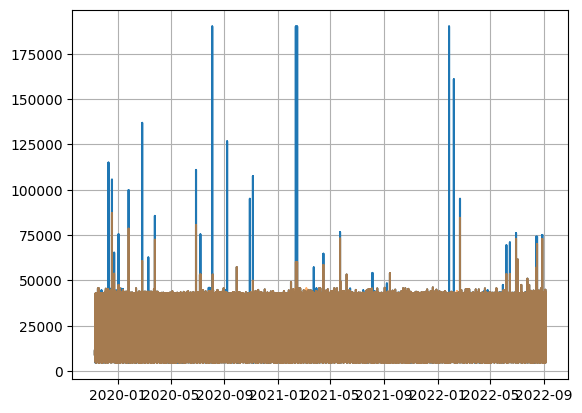

In [17]:
plt.plot(filtered["date"], filtered["weight"])
plt.plot(filtered["date"], filtered["corrected_weight"], alpha=0.6)
plt.grid()

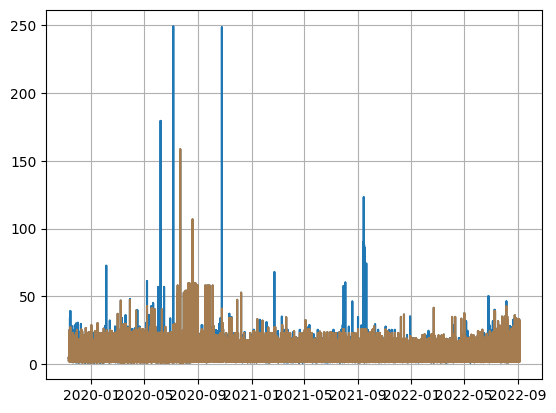

In [18]:
plt.plot(filtered["date"], filtered["rate"])
plt.plot(filtered["date"], filtered["corrected_rate"], alpha=0.6)
plt.grid()

In [19]:
train = (
    train.with_columns(
        c("weight")
        .quantile(0.75)
        .over("kma_track", "transport_type")
        .alias("q75_weight"),
        c("weight")
        .quantile(0.25)
        .over("kma_track", "transport_type")
        .alias("q25_weight"),
        c("rate").quantile(0.75).over("kma_track", "transport_type").alias("q75_rate"),
        c("rate").quantile(0.25).over("kma_track", "transport_type").alias("q25_rate"),
    )
    .with_columns(
        pl.when(c("rate") > (c("q75_rate") + 1.5 * (c("q75_rate") - c("q25_rate"))))
        .then(c("q75_rate") + 1.5 * (c("q75_rate") - c("q25_rate")))
        .when(c("rate") < (c("q25_rate") - 1.5 * (c("q75_rate") - c("q25_rate"))))
        .then(c("q25_rate") - 1.5 * (c("q75_rate") - c("q25_rate")))
        .otherwise(c("rate"))
        .alias("rate")
    )
    .with_columns(
        pl.when(
            c("weight") > c("q75_weight") + 1.5 * (c("q75_weight") - c("q25_weight"))
        )
        .then(c("q75_weight") + 1.5 * (c("q75_weight") - c("q25_weight")))
        .when(
            c("weight") < (c("q25_weight") - 1.5 * (c("q75_weight") - c("q25_weight")))
        )
        .then(c("q25_weight") - 1.5 * (c("q75_weight") - c("q25_weight")))
        .otherwise(c("weight"))
        .alias("weight")
    )
    .drop("q75_weight", "q25_weight", "q75_rate", "q25_rate")
)

### split train into train_df and eval_df
- eval_df for validation set, during catboost fit

In [20]:
train_df = train.filter(
    c("pickup_date").dt.date() < train["pickup_date"].max().date() - timedelta(days=22)
)
eval_df = train.filter(
    c("pickup_date").dt.date() >= train["pickup_date"].max().date() - timedelta(days=22)
)

### kma features
- calculate median rate for transport_type and kma_pair
- calculate median miles for kma_track

In [21]:
kma_transport_median = (
    train.group_by("kma_pair", "transport_type").agg(
        c("rate").count().alias("kma_transport_count"),
        c("rate").median().alias("kma_transport_rate_median"),
    )
    # .sort("kma_transport_count")
    # .filter(c("kma_transport_count") >= 5)
    .drop("kma_transport_count")
)
kma_transport_median.head()

kma_pair,transport_type,kma_transport_rate_median
str,str,f64
"""DLGVW_MJJOV""","""KFEGT""",4.3527
"""RJGHA_JHFLR""","""KFEGT""",5.3032
"""NKFBU_NTODX""","""MKPFX""",3.1263
"""QCLHO_UXLVW""","""MKPFX""",2.4359
"""VKUUR_DNDBK""","""MKPFX""",4.1353


In [22]:
kma_track_median = train.group_by("kma_track").agg(
    c("valid_miles").median().alias("kma_track_miles_median"),
    c("rate").median().alias("kma_track_rate_median"),
)

In [23]:
# fill 0 for new "kma_pair", "transport_type" combination


def add_kma_median(df: pl.DataFrame) -> pl.DataFrame:
    df = df.join(
        kma_transport_median,
        on=["kma_pair", "transport_type"],
        how="left",
    ).with_columns(
        c("kma_transport_rate_median").fill_null(0),
    )
    df = df.join(
        kma_track_median,
        on=["kma_track"],
        how="left",
    ).with_columns(
        c("kma_track_miles_median").fill_null(0),
        c("kma_track_rate_median").fill_null(0),
    )
    return df

In [24]:
train_df = add_kma_median(train_df)
eval_df = add_kma_median(eval_df)
train = add_kma_median(train)
validation = add_kma_median(validation)
test = add_kma_median(test)
train_df.head()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median
f64,f64,str,f64,datetime[μs],str,str,i8,i8,i8,i32,date,i64,i64,f64,f64,str,str,f64,f64,f64
4.7203,6.257371,"""MKPFX""",9231.75,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.8175e6,17.690594,"""OMUOI_LFUHN""","""LFUHN_OMUOI""",4.6315,6.286283,4.6315
4.9005,6.277897,"""MKPFX""",11754.95,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,6.2615e6,22.068082,"""OMUOI_LFUHN""","""LFUHN_OMUOI""",4.6315,6.286283,4.6315
4.7018,6.261337,"""MKPFX""",9603.2,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,5.0313e6,18.329558,"""OMUOI_LFUHN""","""LFUHN_OMUOI""",4.6315,6.286283,4.6315
4.6388,6.332977,"""MKPFX""",8789.05,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.9467e6,15.615828,"""OMUOI_LFUHN""","""LFUHN_OMUOI""",4.6315,6.286283,4.6315
5.0206,6.253595,"""MKPFX""",9597.5,2019-11-10 10:42:00,"""OMUOI""","""LFUHN""",11,7,45,2019,2019-11-10,1,0,4.9895e6,18.461055,"""OMUOI_LFUHN""","""LFUHN_OMUOI""",4.6315,6.286283,4.6315


#### analyze if feature is good

In [26]:
train_df.select("rate", "kma_transport_rate_median").corr()

rate,kma_transport_rate_median
f64,f64
1.0,0.89582
0.89582,1.0


In [27]:
mape_f(validation["rate"], validation["kma_transport_rate_median"])

19.3

In [27]:
mape_f(validation["rate"], validation["kma_track_rate_median"])

19.41

## lag features

### for rolling median by "kma_pair", "transport_type"

#### transform

In [124]:
shifted_week_rate = (
    train_df.group_by("date", "kma_pair", "transport_type")
    .agg(
        c("rate").median(),
    )
    .sort("date")
    .with_columns(
        c("rate")
        .rolling_median(window_size=7, center=False, min_samples=1)
        .over("kma_pair", "transport_type")
        .alias("rolling_rate"),
    )
    .with_columns(
        c("rolling_rate")
        .shift(1)
        .over("kma_pair", "transport_type")
        .alias("shifted_week_rate"),
    )
    .with_columns(
        c("shifted_week_rate").forward_fill().over("kma_pair", "transport_type")
    )
    .select(
        "date",
        "kma_pair",
        "transport_type",
        "shifted_week_rate",
    )
)

transformed_train_df = train_df.join(
    shifted_week_rate,
    on=["date", "kma_pair", "transport_type"],
    how="left",
)

In [125]:
transformed_train_df.shape

(289693, 22)

In [126]:
transformed_train_df.null_count()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10005


In [127]:
transformed_train_df = transformed_train_df.drop_nulls()

In [128]:
def add_kma_pair_transport_lag_feature(
    train_df: pl.DataFrame,
    eval_df: pl.DataFrame,
) -> pl.DataFrame:

    cols = train_df.columns

    shifted_week_rate = (
        train_df.vstack(
            eval_df.with_columns(
                pl.lit(None).alias("rate"),
            ).select(cols)
        )
        .group_by("date", "kma_pair", "transport_type")
        .agg(
            c("rate").median(),
        )
        .sort("date")
        .with_columns(
            c("rate")
            .rolling_median(window_size=7, center=False, min_samples=1)
            .over("kma_pair", "transport_type")
            .alias("rolling_rate"),
        )
        .with_columns(
            c("rolling_rate")
            .shift(1)
            .over("kma_pair", "transport_type")
            .alias("shifted_week_rate"),
        )
        .with_columns(
            c("shifted_week_rate").forward_fill().over("kma_pair", "transport_type")
        )
        .select(
            "date",
            "kma_pair",
            "transport_type",
            "shifted_week_rate",
        )
    )

    transformed_eval_df = eval_df.join(
        shifted_week_rate,
        on=["date", "kma_pair", "transport_type"],
        how="left",
    )

    return transformed_eval_df

In [129]:
transformed_eval_df = add_kma_pair_transport_lag_feature(train_df, eval_df)

In [130]:
transformed_validation = add_kma_pair_transport_lag_feature(train, validation)

In [131]:
transformed_test = add_kma_pair_transport_lag_feature(
    train_df.vstack(eval_df).vstack(validation), test
)

In [132]:
transformed_eval_df.null_count()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173


In [133]:
transformed_validation.null_count()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180


In [134]:
transformed_validation = transformed_validation.with_columns(
    c("shifted_week_rate").fill_null(strategy="mean"),
)
transformed_eval_df = transformed_eval_df.with_columns(
    c("shifted_week_rate").fill_null(strategy="mean"),
)
transformed_test = transformed_test.with_columns(
    c("shifted_week_rate").fill_null(strategy="mean"),
)

In [135]:
transformed_eval_df.null_count()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### analyze if feature is good

In [136]:
metric = mape_f(
    transformed_eval_df.drop_nulls()["rate"],
    transformed_eval_df.drop_nulls()["shifted_week_rate"],
)
print("transformed_eval_df \t", metric)
metric = mape_f(
    transformed_validation.drop_nulls()["rate"],
    transformed_validation.drop_nulls()["shifted_week_rate"],
)
print("transformed_validation \t", metric)

transformed_eval_df 	 12.27
transformed_validation 	 13.56


### rate trend feature

#### plot

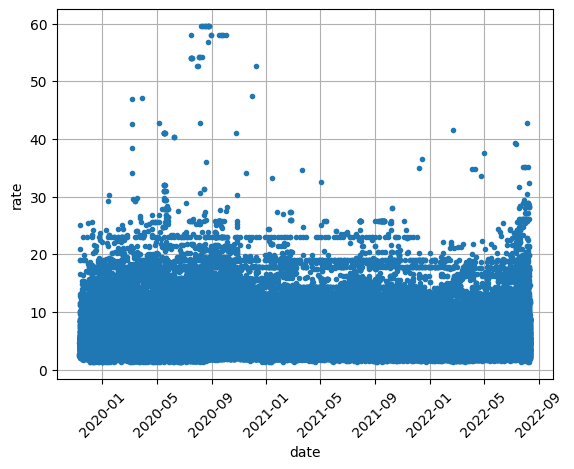

In [137]:
# There is too much deviation per each day

plt.plot(transformed_train_df["date"], transformed_train_df["rate"], ".")
plt.xlabel("date")
plt.ylabel("rate")
plt.xticks(rotation=45)
plt.grid()

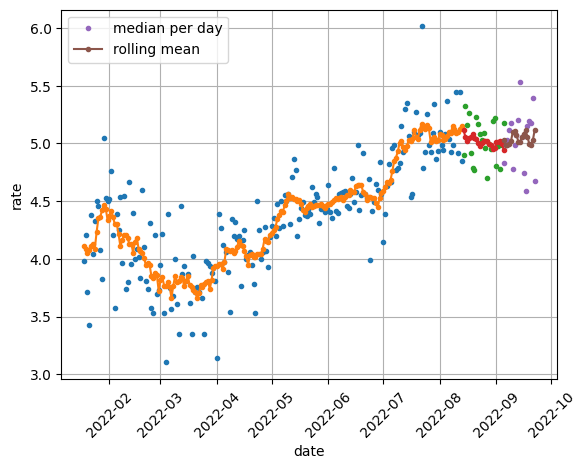

In [138]:
trend = (
    train_df.group_by("date")
    .agg(
        c("rate").median().alias("median_rate"),
    )
    .sort("date")
)

window_size = 9
min_samples = window_size // 2
trend = (
    trend.sort("date")
    .with_columns(
        c("median_rate").rolling_mean(
            window_size=window_size,
            min_samples=min_samples,
            center=True,
        )
        # .over("weekday")
        .alias("rolling_mean")
    )
    .with_columns(
        c("rolling_mean")
        .shift(
            21,
        )
        .alias("shifted_rolling_mean")
    )
)

plt.plot(trend["date"][800:], trend["median_rate"][800:], ".")
plt.plot(trend["date"][800:], trend["rolling_mean"][800:], ".-")

trend = (
    transformed_eval_df.group_by("date")
    .agg(
        c("rate").median().alias("median_rate"),
    )
    .sort("date")
)

window_size = 9
min_samples = window_size // 2
trend = trend.sort("date").with_columns(
    c("median_rate").rolling_mean(
        window_size=window_size,
        min_samples=min_samples,
        center=True,
    )
    # .over("weekday")
    .alias("rolling_mean")
)

plt.plot(trend["date"], trend["median_rate"], ".")
plt.plot(trend["date"], trend["rolling_mean"], ".-")

trend = (
    transformed_validation.group_by("date")
    .agg(
        c("rate").median().alias("median_rate"),
    )
    .sort("date")
)

window_size = 9
min_samples = window_size // 2
trend = trend.sort("date").with_columns(
    c("median_rate").rolling_mean(
        window_size=window_size,
        min_samples=min_samples,
        center=True,
    )
    # .over("weekday")
    .alias("rolling_mean")
)

plt.plot(trend["date"], trend["median_rate"], ".", label="median per day")
plt.plot(trend["date"], trend["rolling_mean"], ".-", label="rolling mean")
plt.xlabel("date")
plt.ylabel("rate")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

#### transform

In [139]:
validation["date"].unique().shape

(18,)

In [140]:
# have to make shift of 23 days
test["date"].unique().shape

(23,)

In [141]:
trend = (
    train_df.group_by("date")
    .agg(
        c("rate").median().alias("median_rate"),
    )
    .sort("date")
)

window_size = 9
min_samples = window_size // 2
trend = (
    trend.sort("date")
    .with_columns(
        c("median_rate")
        .rolling_mean(
            window_size=window_size,
            min_samples=min_samples,
            center=True,
        )
        .alias("rolling_mean"),
    )
    .with_columns(
        c("rolling_mean").shift(23).alias("shifted_trend"),
    )
    .select("date", "shifted_trend")
    .drop_nulls()
)

transformed_train_df = transformed_train_df.join(
    trend,
    on=["date"],
    how="left",
)

In [142]:
transformed_train_df.null_count()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate,shifted_trend
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3107


In [143]:
transformed_train_df = transformed_train_df.drop_nulls()

In [144]:
def add_rate_trend_feature(
    train_df: pl.DataFrame,
    eval_df: pl.DataFrame,
) -> pl.DataFrame:

    cols = train_df.columns

    trend = (
        train_df.vstack(
            eval_df.with_columns(
                pl.lit(None).alias("rate"),
            ).select(cols)
        )
        .group_by("date")
        .agg(
            c("rate").median().alias("median_rate"),
        )
        .sort("date")
    )

    window_size = 9
    min_samples = window_size // 2
    trend = (
        trend.sort("date")
        .with_columns(
            c("median_rate")
            .rolling_mean(
                window_size=window_size,
                min_samples=min_samples,
                center=True,
            )
            .alias("rolling_mean"),
        )
        .with_columns(
            c("rolling_mean").shift(23).alias("shifted_trend"),
        )
        .select("date", "shifted_trend")
    )

    transformed_eval_df = eval_df.join(
        trend,
        on="date",
        how="left",
    )

    return transformed_eval_df

In [145]:
transformed_eval_df = add_rate_trend_feature(train_df, transformed_eval_df)

In [146]:
transformed_test = add_rate_trend_feature(
    train_df.vstack(eval_df).vstack(validation), transformed_test
)

In [147]:
transformed_validation = add_rate_trend_feature(
    train_df.vstack(eval_df), transformed_validation
)

In [148]:
transformed_test.null_count()

valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate,shifted_trend
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### analyze if feature is good

In [149]:
transformed_eval_df.select("rate", "shifted_trend").corr()

rate,shifted_trend
f64,f64
1.0,-0.006671
-0.006671,1.0


In [150]:
mape_f(transformed_validation["rate"], transformed_validation["shifted_trend"])

33.6

In [151]:
mape_f(transformed_eval_df["rate"], transformed_eval_df["shifted_trend"])

34.96

### demand feature

#### plot

In [152]:
demand_rate = (
    transformed_train_df.group_by("date")
    .agg(
        c("rate").median().alias("median_rate"),
        c("rate").count().alias("demand"),
    )
    .sort("date")
)

In [153]:
demand_rate = add_date_features(demand_rate.rename({"date": "pickup_date"}))

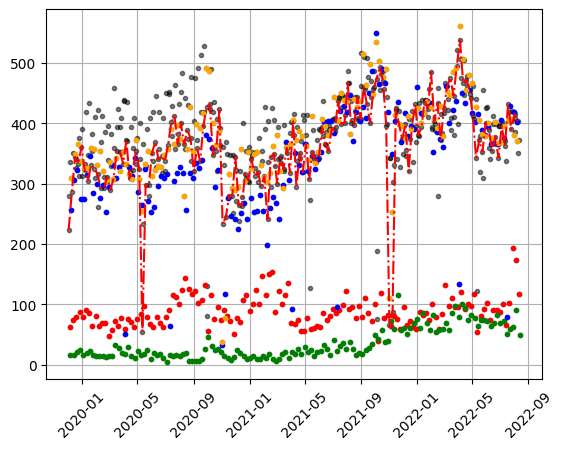

In [154]:
plt.plot(demand_rate["date"], demand_rate["demand"], ".", color="black", alpha=0.5)
plt.plot(
    demand_rate.filter(c("weekday") == 5)["date"],
    demand_rate.filter(c("weekday") == 5)["demand"],
    ".",
    color="red",
)
plt.plot(
    demand_rate.filter(c("weekday") == 6)["date"],
    demand_rate.filter(c("weekday") == 6)["demand"],
    ".",
    color="green",
)
plt.plot(
    demand_rate.filter(c("weekday") == 7)["date"],
    demand_rate.filter(c("weekday") == 7)["demand"],
    ".",
    color="blue",
)
plt.plot(
    demand_rate.filter(c("weekday") == 1)["date"],
    demand_rate.filter(c("weekday") == 1)["demand"],
    ".",
    color="orange",
)
plt.plot(
    demand_rate.filter(c("weekday") == 2)["date"],
    demand_rate.filter(c("weekday") == 2)["demand"],
    "-.",
    color="red",
)
plt.xticks(rotation=45)
plt.grid()

In [155]:
window_size = 9
min_samples = window_size // 2
demand_rate = demand_rate.sort("date").with_columns(
    c("demand")
    .rolling_mean(
        window_size=window_size,
        min_samples=min_samples,
        center=True,
    )
    .over("weekday")
    .alias("rolling_mean")
)

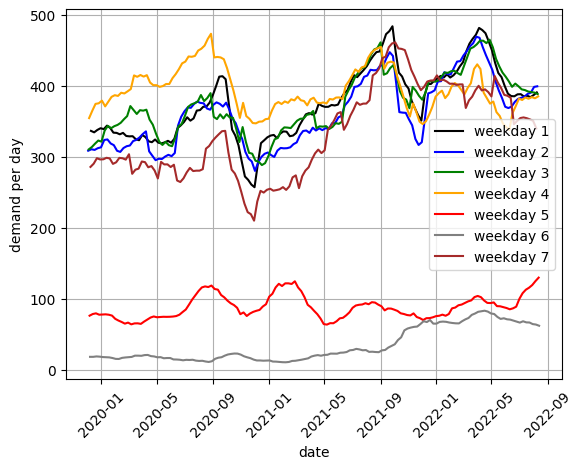

In [156]:
colors = ["black", "blue", "green", "orange", "red", "grey", "brown"]
for i in range(1, 8):
    plt.plot(
        demand_rate.filter(c("weekday") == i)["date"],
        demand_rate.filter(c("weekday") == i)["rolling_mean"],
        "-",
        color=colors[i - 1],
        label=f"weekday {i}",
    )
    # plt.plot(
    #     demand_rate.filter(c("weekday") == i)["date"],
    #     demand_rate.filter(c("weekday") == i)["demand"],
    #     ".",
    #     color=colors[i-1],
    # )
plt.xticks(rotation=45)
plt.legend()
plt.xlabel("date")
plt.ylabel("demand per day")
plt.grid()

#### transform

In [157]:
demand_rate = (
    transformed_train_df.group_by("date")
    .agg(
        c("valid_miles").count().alias("demand"),
    )
    .sort("date")
)

In [158]:
def add_demand_feature(df: pl.DataFrame) -> pl.DataFrame:
    df = (
        df.sort("date")
        .with_columns(c("valid_miles").count().over("date").alias("demand"))
        .with_columns(
            c("demand")
            .rolling_mean(
                window_size=window_size,
                min_samples=1,
                center=False,
            )
            .over("weekday")
            .alias("rolling_mean_demand")
        )
        .drop("demand")
    )
    return df

In [159]:
transformed_validation = add_demand_feature(transformed_validation)

In [160]:
transformed_eval_df = add_demand_feature(transformed_eval_df)

In [161]:
transformed_train_df = add_demand_feature(transformed_train_df)

In [162]:
transformed_test = add_demand_feature(transformed_test)

#### analyze if feature is good

In [164]:
transformed_train_df.select("rolling_mean_demand", "rate").corr()

rolling_mean_demand,rate
f64,f64
1.0,-0.018977
-0.018977,1.0


### Applying Sine and Cosine Transformation to date features

In [165]:
def transform_date_features(df: pl.DataFrame) -> pl.DataFrame:

    df = df.with_columns(
        (c("month") * (2.0 * np.pi / 12)).sin().alias("month_sin"),
        (c("month") * (2.0 * np.pi / 12)).cos().alias("month_cos"),
        (c("weekday") * (2.0 * np.pi / 7)).sin().alias("weekday_sin"),
        (c("weekday") * (2.0 * np.pi / 7)).cos().alias("weekday_cos"),
        (c("week") * (2.0 * np.pi / 53)).sin().alias("week_sin"),
        (c("week") * (2.0 * np.pi / 53)).cos().alias("week_cos"),
    ).drop("month", "weekday", "week")
    return df

In [166]:
transformed_train_df = transform_date_features(transformed_train_df)
transformed_eval_df = transform_date_features(transformed_eval_df)
transformed_validation = transform_date_features(transformed_validation)
transformed_test = transform_date_features(transformed_test)
transformed_train_df.head()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate,shifted_trend,rolling_mean_demand,month_sin,month_cos,weekday_sin,weekday_cos,week_sin,week_cos
f64,f64,str,f64,datetime[μs],str,str,i32,date,i64,i64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
6.0549,6.289558,"""MKPFX""",16295.0,2019-12-03 00:12:00,"""RUEXZ""","""QWBPO""",2019,2019-12-03,0,0,8.7816e6,30.236662,"""RUEXZ_QWBPO""","""QWBPO_RUEXZ""",4.8712,6.270552,4.844,5.6933,4.8407,223.0,-2.4493e-16,1.0,0.974928,-0.222521,-0.456629,0.889657
15.73535,3.637028,"""MKPFX""",30761.125,2019-12-03 00:12:00,"""NTODX""","""JESUD""",2019,2019-12-03,0,0,1481173.2,1026.888685,"""NTODX_JESUD""","""JESUD_NTODX""",15.5373,4.18147,8.9656,15.73535,4.8407,223.0,-2.4493e-16,1.0,0.974928,-0.222521,-0.456629,0.889657
5.7211,6.057612,"""GJROY""",40814.5,2019-12-03 00:42:00,"""PEXPT""","""NPCXM""",2019,2019-12-03,0,0,1.7442e7,95.505176,"""PEXPT_NPCXM""","""NPCXM_PEXPT""",4.2094,6.139318,3.5162,5.3397,4.8407,223.0,-2.4493e-16,1.0,0.974928,-0.222521,-0.456629,0.889657
6.5677,4.809508,"""MKPFX""",39624.15,2019-12-03 00:42:00,"""VCEUE""","""HECXW""",2019,2019-12-03,0,0,4.8607e6,323.011025,"""VCEUE_HECXW""","""HECXW_VCEUE""",7.256,5.064985,6.6746,6.1572,4.8407,223.0,-2.4493e-16,1.0,0.974928,-0.222521,-0.456629,0.889657
7.3624,5.579394,"""MKPFX""",40748.0,2019-12-03 00:42:00,"""AQUVM""","""KPOER""",2019,2019-12-03,0,0,1.0795e7,153.817697,"""AQUVM_KPOER""","""AQUVM_KPOER""",5.5218,5.579394,5.5268,6.90225,4.8407,223.0,-2.4493e-16,1.0,0.974928,-0.222521,-0.456629,0.889657


### save dataframes

In [167]:
path = os.path.join("../", DATA_DIR, "train_df.parquet")
transformed_train_df.write_parquet(path)

path = os.path.join("../", DATA_DIR, "eval_df.parquet")
transformed_eval_df.write_parquet(path)

path = os.path.join("../", DATA_DIR, "validation.parquet")
transformed_validation.write_parquet(path)

path = os.path.join("../", DATA_DIR, "test.parquet")
transformed_test.write_parquet(path)